# VGG Fun!

VGG (Simonyan, K., & Zisserman, A. (2014)) is a deep convolutional neural network designed by the Visual Geometry Group at Oxford University. It belongs to the generation of networks immediately following the breakthrough AlexNet. It was notable for its depth (up to 19 learnable layers) and simple design principles. For example, (padded) $3\times 3$ convolutions are used everywhere, given that a stack of three $3 \times 3$ convolutions with $C$ channels has a receptive field of size $7 \times 7$ despite having $27C^2$ weights, fewer than a single $7 \times 7$ kernel at $49C^2$.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import numpy as np
import matplotlib.pyplot as plt

## Load data

We train on CIFAR100. Without any modification this same network will give $\sim 92\%$ test accuracy on CIFAR10.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import Subset
from sklearn.model_selection import train_test_split


root_dir = './'
output_dir = './'

train_transform = transforms.Compose([
    transforms.RandomCrop(32, 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])  # channel-wise means/stds

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))])  # channel-wise means/stds

train_set = torchvision.datasets.CIFAR100(root=root_dir, train=True,
                                         download=True, transform=train_transform)

nb_train = len(train_set.targets)
idx_train, idx_val = train_test_split(np.arange(nb_train), test_size=5000)

train_sub = Subset(train_set, idx_train)
test_sub = Subset(train_set, idx_val)

batch_size = 128

train_loader = torch.utils.data.DataLoader(train_sub, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(test_sub, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

test_set = torchvision.datasets.CIFAR100(root=root_dir, train=False,
                                        download=True, transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = train_set.classes
nb_classes = len(classes)
print(classes)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

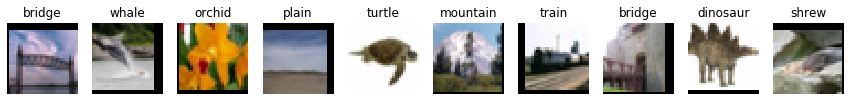

In [4]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

fig, axes = plt.subplots(figsize=(15, 3), ncols=10)

for i in range(10):
    img = 0.25 * images[i].permute(1, 2, 0) + 0.5
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(classes[labels[i]])

## Create net

We program configuration D from Simonyan, K., & Zisserman, A. (2014) with smaller fully-connected layers (512 neurons each instead of 4096). The total number of parameters is about 15M i.e. $10\times$ smaller than the full ImageNet design. This illustrates how top-heavy the full version is. We also add batch normalisation after every convolutional layer.

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Conv_BN_ReLU(nn.Module):

    def __init__(self, in_ch, out_ch, stride=1):

        super(Conv_BN_ReLU, self).__init__()

        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        return self.conv_bn_relu(x)


class VGG16(nn.Module):

    def __init__(self):

        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            Conv_BN_ReLU(3, 64),
            Conv_BN_ReLU(64, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv_BN_ReLU(64, 128),
            Conv_BN_ReLU(128, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv_BN_ReLU(128, 256),
            Conv_BN_ReLU(256, 256),
            Conv_BN_ReLU(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv_BN_ReLU(256, 512),
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512),
            Conv_BN_ReLU(512, 512),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, nb_classes)
        )

    def forward(self, x):

        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)

        return x
    
net = VGG16().to(device)

## Train model

We train for 200 epochs, halving the learning rate every 30 epochs. This takes about 1 hour on a Tesla P100 SXM2.

In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

def learning_rate_schedule(epoch):
    return 2 ** -(epoch // 30)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
scheduler = LambdaLR(optimizer, lr_lambda=learning_rate_schedule)

val_data = iter(val_loader).next()
x_val, y_val = val_data[0].to(device), val_data[1].to(device)
val_acc_best = 0
val_accs = []

In [8]:
def top_k_accuracy(outputs, y_val, k=1):

    """ Calculates top k accuracy for prediction

    Note top-k for k > 1 is only meaningful when modelling
    many similar classes.
    """

    top_k = torch.argsort(outputs, descending=True)[:, :k]
    in_top_k = torch.sum(top_k == y_val[:, None], axis=1)
    top_k_acc = torch.mean(in_top_k.double()).item()

    return top_k_acc

nb_epochs = 200

for epoch in range(nb_epochs):  # loop over the dataset multiple times

    running_loss = 0.0

    net = net.train()

    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero gradients
        optimizer.zero_grad()

        # feed forward
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backpropagate
        loss.backward()
        # gradient descent
        optimizer.step()

        running_loss += loss.item() * batch_size / len(train_sub.indices)

    net = net.eval()

    with torch.no_grad():

        val_outputs = torch.cat([net(data.to(device)) for data, _ in val_loader])
        val_targets = torch.cat([target for _, target in val_loader]).to(device)

        top_1_acc = top_k_accuracy(val_outputs, val_targets, k=1)
        top_3_acc = top_k_accuracy(val_outputs, val_targets, k=3)
        
        val_accs.append(top_1_acc)

        val_loss = criterion(val_outputs, val_targets).item()  # N.B. item() important

        print('[%04d] train_loss: %.4f val_loss: %.4f top_1_acc: %.4f top_3_acc: %.4f' % (
            epoch, running_loss, val_loss, top_1_acc, top_3_acc))

        if top_1_acc > val_acc_best:
            val_acc_best = top_1_acc
            torch.save(net.state_dict(), os.path.join(output_dir, './cnn.torch'))

    # update learning rate
    scheduler.step()

[0000] train_loss: 4.3859 val_loss: 4.2560 top_1_acc: 0.0360 top_3_acc: 0.0832
[0001] train_loss: 4.1794 val_loss: 4.0912 top_1_acc: 0.0498 top_3_acc: 0.1370
[0002] train_loss: 4.0176 val_loss: 3.9959 top_1_acc: 0.0512 top_3_acc: 0.1530
[0003] train_loss: 3.8550 val_loss: 3.7348 top_1_acc: 0.0848 top_3_acc: 0.2224
[0004] train_loss: 3.6261 val_loss: 3.6492 top_1_acc: 0.1004 top_3_acc: 0.2504
[0005] train_loss: 3.4354 val_loss: 3.3436 top_1_acc: 0.1464 top_3_acc: 0.3222
[0006] train_loss: 3.2515 val_loss: 3.1106 top_1_acc: 0.1796 top_3_acc: 0.3838
[0007] train_loss: 3.0796 val_loss: 3.2420 top_1_acc: 0.1646 top_3_acc: 0.3700
[0008] train_loss: 2.9148 val_loss: 2.9831 top_1_acc: 0.2254 top_3_acc: 0.4420
[0009] train_loss: 2.7658 val_loss: 2.7547 top_1_acc: 0.2602 top_3_acc: 0.4912
[0010] train_loss: 2.6343 val_loss: 2.7342 top_1_acc: 0.2746 top_3_acc: 0.4968
[0011] train_loss: 2.5174 val_loss: 2.4800 top_1_acc: 0.3156 top_3_acc: 0.5622
[0012] train_loss: 2.4275 val_loss: 2.4637 top_1_acc

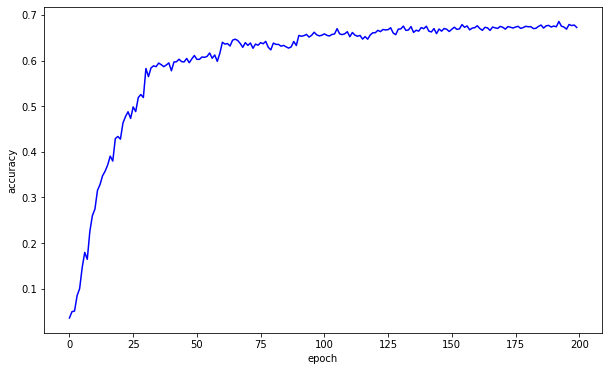

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

_ = ax.plot(val_accs, color='blue')
_ = ax.set_xlabel('epoch')
_ = ax.set_ylabel('accuracy')

We see how the validation accuracy jumps every 30 epochs, in time with the learning rate schedule.

## Test model

In [10]:
net = VGG16().to(device)
net.load_state_dict(torch.load(os.path.join(output_dir, './cnn.torch'), map_location=torch.device('cpu')))
net.eval()

with torch.no_grad():

    test_outputs = torch.cat([net(data.to(device)) for data, _ in test_loader])
    test_targets = torch.cat([target for _, target in test_loader]).to(device)

    top_1_acc = top_k_accuracy(test_outputs, test_targets, k=1)
    top_3_acc = top_k_accuracy(test_outputs, test_targets, k=3)

    print('[Evaluation] top_1_acc: %.4f top_3_acc: %.4f' % (top_1_acc, top_3_acc))

[Evaluation] top_1_acc: 0.6938 top_3_acc: 0.8388


### Feature visualisation

Zeiler, M. D., & Fergus, R. (2013) demonstrated a technique for visualising ConvNet features, by performing image reconstruction with their previously developed DeconvNet (Zeiler, M. D., Krishnan, D., Taylor, G. W., & Fergus, R. (2010)). A DeconvNet is a deep, unsupervised model that learns a hierarchy of convolutional filters by decomposing input images into a sum of convolutions (effectively inverting a ConvNet). Note that in their 2013 paper, they also presented a minor improvement to AlexNet, yielding a network sometimes called ZFNet.

After this, VGG creators Simonyan, K., Vedaldi, A., & Zisserman, A. (2013) proposed a simpler approach based on iteratively optimising an image to maximise a given neuron in the network,

$$\arg\max_I S_C(I) - \lambda||I||_2^2$$

where $S_C$ is the logit of class $C$. This technique they showed to roughly generalise the DeconvNet approach. We can also explore the convolutional kernels, by taking an average over their activations. For this we use the full VGG16, pretrained on ImageNet.

In [11]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True)

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)

In [12]:
def gen_image(layer, filter_num, num_epochs=30, lr=1e-1, lam=1e-2):
    
    x = torch.zeros(1, 3, 224, 224).requires_grad_(True)

    for i in range(num_epochs):

        s_c = torch.mean(layer(x)[0, filter_num])

        loss = s_c - lam * torch.sum(torch.pow(x, 2))
        loss.backward()

        # credit to Chollet for this normalisation trick
        grad = x.grad / (torch.sqrt(torch.mean(torch.pow(x.grad, 2))) + 1e-5)

        x = (x.detach() + lr * grad).requires_grad_(True)
    
    return x[0].detach().permute(1, 2, 0).numpy()

img_1 = gen_image(vgg16.features[:22], 25)
img_2 = gen_image(vgg16.features[:28], 25)

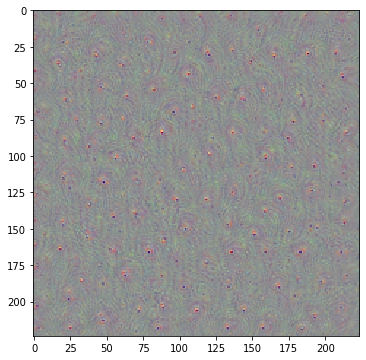

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))

img_1 = (img_1 - np.min(img_1)) / (np.max(img_1) - np.min(img_1))
ax.imshow(img_1)

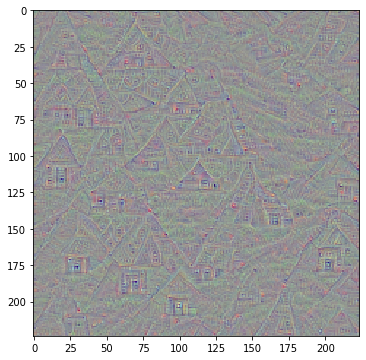

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))

img_2 = (img_2 - np.min(img_2)) / (np.max(img_2) - np.min(img_2))
ax.imshow(img_2)

We observe the emergence of objects and textures pertaining to some image class. Note that this is the basis of techniques like DeepDream. The blog post on DeepDream mentions a prior to ensure neighbouring pixels are correlated. It seems possible that a regulariser consisting of the RMSE of the image convolved with any zero-sum filter might serve that purpose.